### Feature selecture using target permutation

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target).

The notebook implements the following steps  :
 - Create the null importances distributions : these are created fitting the model over several runs on a shuffled version of the target. This shows how the model can make sense of a feature irrespective of the target.
 - Fit the model on the original target and gather the feature importances. This gives us a benchmark whose significance can be tested against the Null Importances Distribution
 

### Import a few packages

In [12]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

### train



In [13]:
data = pd.read_csv('train_titanic.csv')


In [14]:
categorical_feats = [
    f for f in data.drop(['Name','Ticket'],axis=1).columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

### Create a scoring function

Coring function uses LightGBM in RandomForest mode fitted on the full dataset 

In [15]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['Survived', 'PassengerId','Name','Ticket']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['Survived'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['Survived'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
#     imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

### Build the benchmark for feature importance


In [16]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [17]:
actual_imp_df.head()

,feature,importance_split,trn_score
0,Pclass,307,0.89937
1,Sex,149,0.89937
2,Age,1210,0.89937
3,SibSp,201,0.89937
4,Parch,167,0.89937


### Build Null Importances distribution

In [18]:
null_imp_df = pd.DataFrame()
nb_runs = 20 # number of iterations (number of times )
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   20 of   20 (Spent   0.1 min)

In [19]:
null_imp_df.head()

,feature,importance_split,trn_score,run
0,Pclass,219,0.713003,1
1,Sex,248,0.713003,1
2,Age,1075,0.713003,1
3,SibSp,176,0.713003,1
4,Parch,159,0.713003,1


### Display distribution examples

A few plots are better than any words

In [20]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 1)
#     Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
#     ax = plt.subplot(gs[0, 1])
#     a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
#     ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
#                ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
#     ax.legend()
#     ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
#     plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

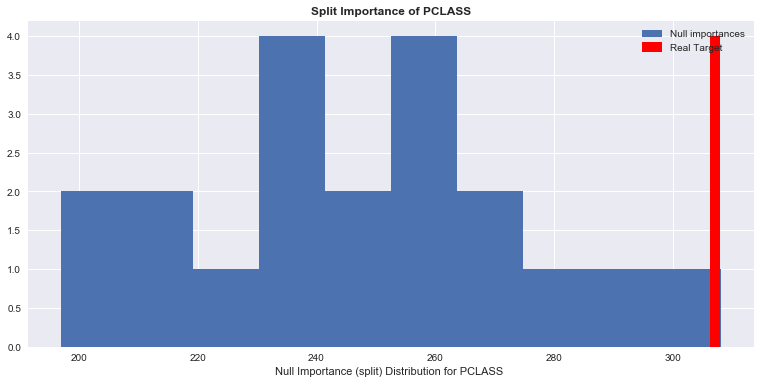

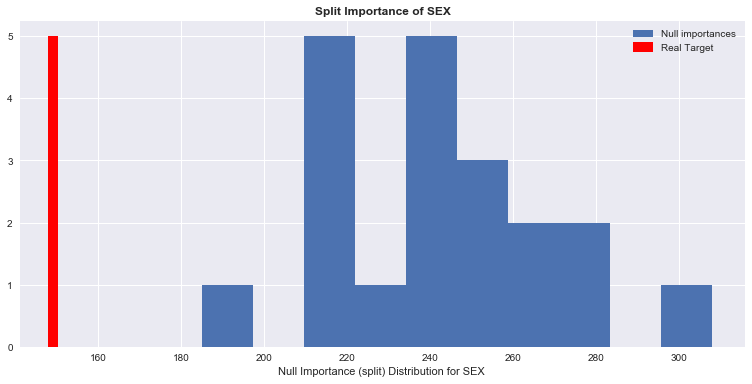

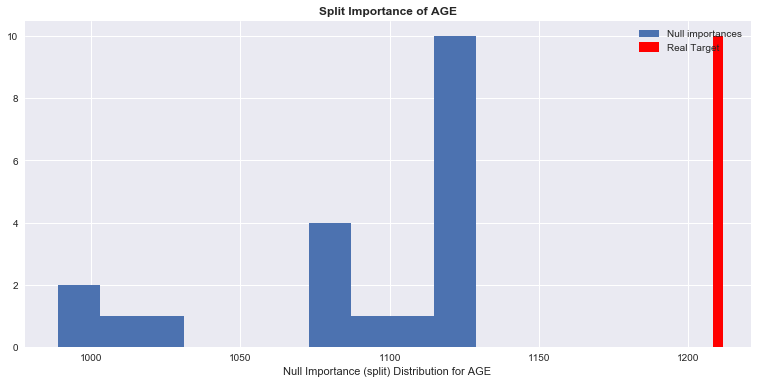

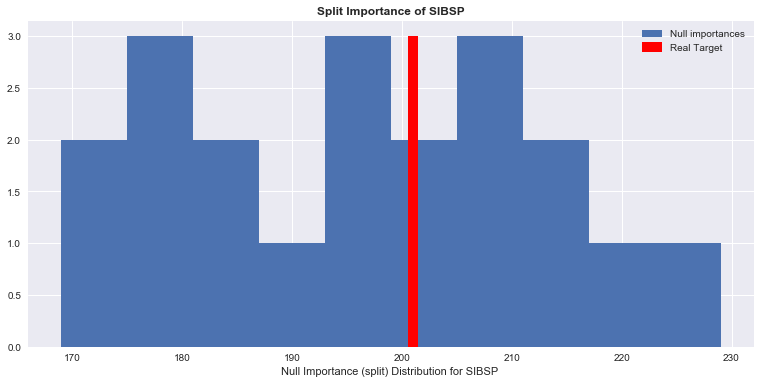

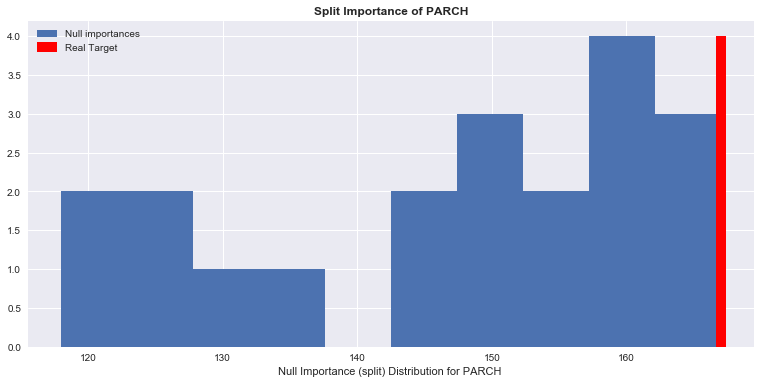

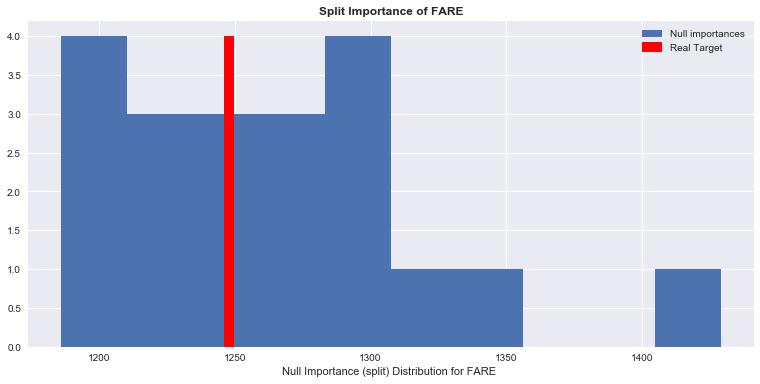

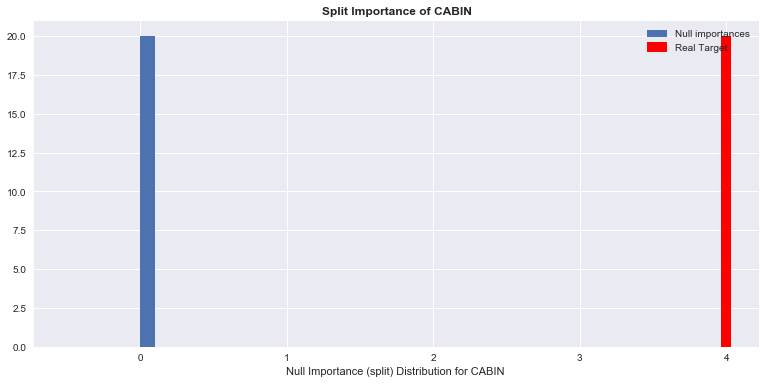

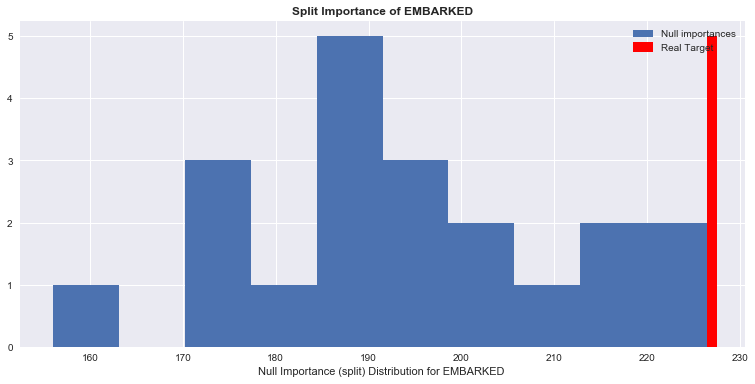

In [10]:
for feature in actual_imp_df.feature.unique():
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature)

From the above plot I believe the power of the exposed feature selection method is demonstrated. In particular it is well known that :
 - Any feature sufficient variance can be used and made sense of by tree models. You can always find splits that help scoring better
 - Correlated features have decaying importances once one of them is used by the model. The chosen feature will have strong importance and its correlated suite will have decaying importances
 
 The current method allows to :
  - Drop high variance features if they are not really related to the target
  - Remove the decaying factor on correlated features, showing their real importance (or unbiased importance)


### Score features

There are several ways to score features : 
 - Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
 - Compute ratios like Actual / Null Max, Actual  / Null Mean,  Actual Mean / Null Max
 
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

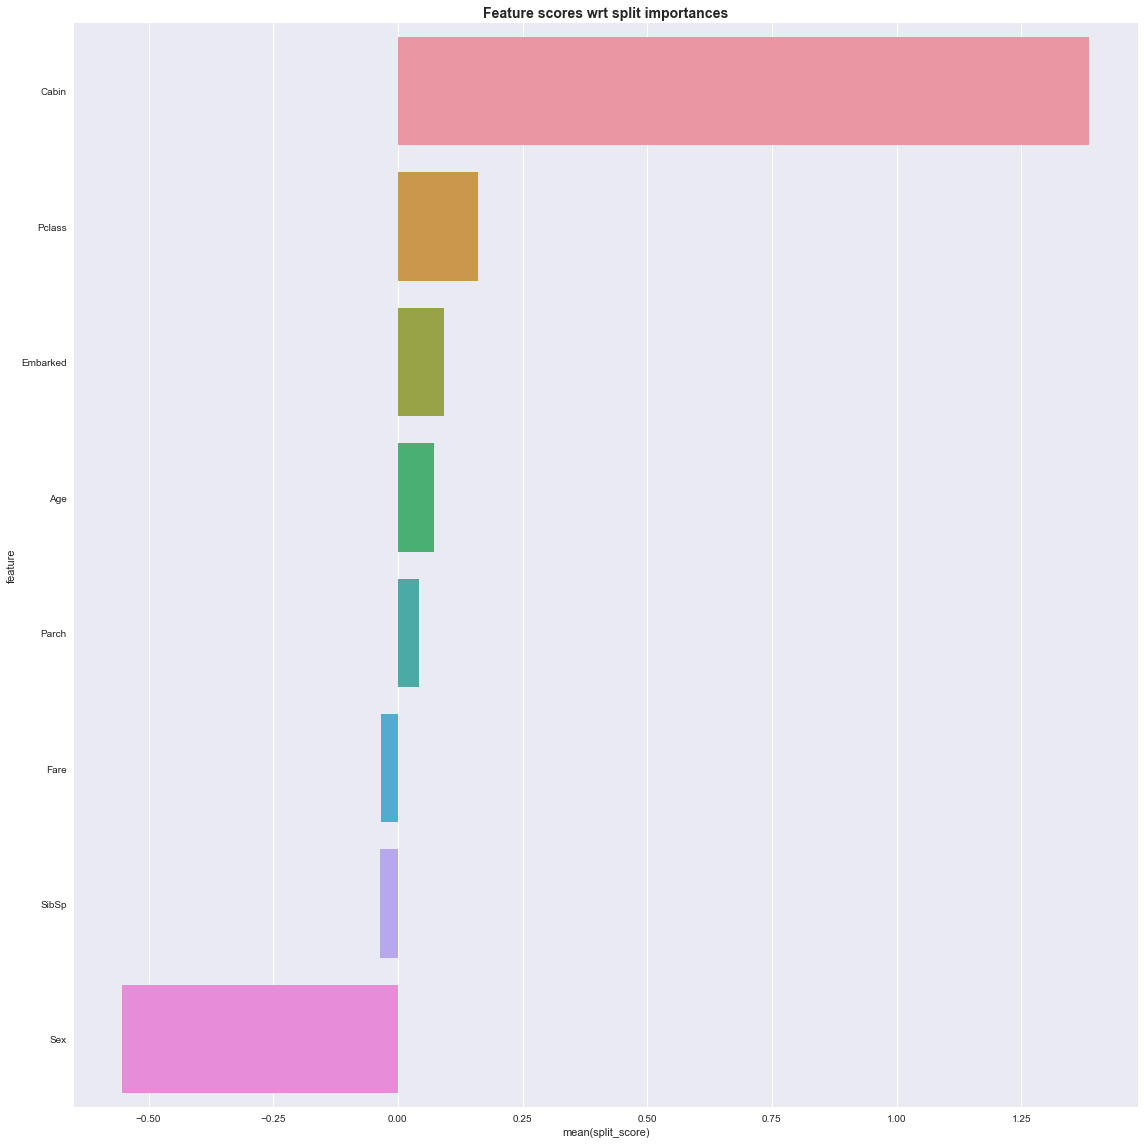

In [21]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
#     f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
#     f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
#     gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()